# Single Inverted Pendulum


This is a classical inverted pendulum. A ball of mass $m$ is attached to a
massless beam of length $L$.  The beam is actuated with a torque $T$ and
we assume viscous friction exists with a coefficient of $c$.

In [1]:
using NeuralNetworkAnalysis
using NeuralNetworkAnalysis: SingleEntryVector

The following option determines whether the falsification settings should be
used or not. The falsification settings are sufficient to show that the safety
property is violated. Concretely we start from an initial point and use a
smaller time step.

In [2]:
const falsification = true;

## Model

The governing equation of motion can be obtained as:

$$
\ddot\theta = \dfrac{g}{L} \sin(\theta) + \dfrac{1}{m L^2} (T - c\dot\theta)
$$
where $θ$ is the angle that the link makes with the upward vertical axis.
The state vector is $[θ, θ']$.

model constants

In [3]:
const m = 0.5
const L = 0.5
const c = 0.0
const g = 1.0
const gL = g/L
const mL = 1/(m*L^2)

@taylorize function single_pendulum!(dx, x, p, t)
    dx[1] = x[2]
    dx[2] = gL * sin(x[1]) + mL*(x[3] - c*x[2])
    dx[3] = zero(x[3])
    return dx
end

controller = read_nnet(@modelpath("Single-Pendulum",
                                  "controller_single_pendulum.nnet"));

## Specification

The initial set is
$$
(\theta, \dot\theta) \in [1, 1.2] \times [0, 0.2].
$$
The safety specification is that $θ ∈ [0, 1]$ for all control steps
$10 ≤ n_t ≤ 20$.

In [4]:
X0 = Hyperrectangle([1.1, 0.1], [0.1, 0.1])
if falsification
    # choose a single point in the initial states (here: the top-most one)
    X0 = Singleton(high(X0))
end
U0 = ZeroSet(1)
ivp = @ivp(x' = single_pendulum!(x), dim: 3, x(0) ∈ X0 × U0)
vars_idx = Dict(:state_vars=>1:2, :control_vars=>3)

period = 0.05  # control period
if falsification
    k = 11
else
    k = 20
end
T = k * period  # time horizon

prob = ControlledPlant(ivp, controller, vars_idx, period)

unsafe_states = HalfSpace(SingleEntryVector(1, 3, -1.0), -1.0)

predicate = X -> overapproximate(X, Hyperrectangle) ⊆ unsafe_states
function predicate_sol(sol; silent::Bool=false)
    for F in sol
        for R in F
            t = tspan(R)
            if t.lo >= 0.5 && t.hi <= 1.0 && predicate(R)
                silent || println("violation for time range $t")
                return true
            end
        end
    end
    return false
end;

## Results

In [5]:
import DifferentialEquations

alg = TMJets(abstol=1e-7, orderT=4, orderQ=1)
alg_nn = Ai2()

function benchmark(; silent::Bool=false)
    # We solve the controlled system:
    silent || println("flowpipe construction")
    res_sol = @timed solve(prob, T=T, alg_nn=alg_nn, alg=alg)
    sol = res_sol.value
    silent || print_timed(res_sol)

    # Next we check the property for an overapproximated flowpipe:
    silent || println("property checking")
    solz = overapproximate(sol, Zonotope)
    res_pred = @timed predicate_sol(solz; silent=silent)
    silent || print_timed(res_pred)
    if res_pred.value
        silent || println("The property is violated.")
    else
        silent || println("The property may be satisfied.")
    end

    # We also compute some simulations:
    silent || println("simulation")
    trajectories = falsification ? 1 : 10
    res_sim = @timed simulate(prob, T=T, trajectories=trajectories,
                              include_vertices=!falsification)
    sim = res_sim.value
    silent || print_timed(res_sim)

    return solz, sim
end;

benchmark(silent=true)  # warm-up
res = @timed benchmark()  # benchmark
sol, sim = res.value
println("total analysis time")
print_timed(res);

flowpipe construction
  0.275835 seconds (2.88 M allocations: 265.410 MiB)
property checking
violation for time range [0.5, 0.509134]
  0.065702 seconds (40.04 k allocations: 2.401 MiB)
The property is violated.
simulation
  0.001666 seconds (3.58 k allocations: 308.000 KiB)
total analysis time
  0.371055 seconds (3.05 M allocations: 279.323 MiB)


Finally we plot the results:

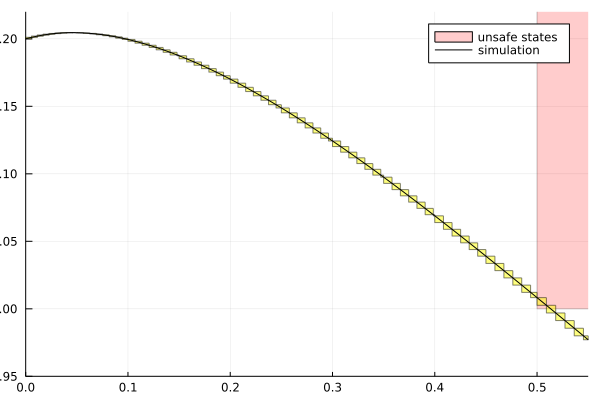

In [6]:
using Plots
import DisplayAs

vars = (0, 1)
fig = plot(ylab="θ")
unsafe_states_projected = project(unsafe_states, [vars[2]])
time = Interval(0.5, 1.0)
unsafe_states_projected = cartesian_product(time, unsafe_states_projected)
plot!(fig, unsafe_states_projected, color=:red, alpha=:0.2, lab="unsafe states")
time0 = Singleton([0.0])
if !falsification
    plot!(fig, cartesian_product(time0, project(initial_state(prob), [vars[2]])),
          lab="X₀")
end
plot!(fig, sol, vars=vars, color=:yellow, lab="")
if falsification
    xlims!(0, T)
    ylims!(0.95, 1.22)
else
    xlims!(0, T)
    ylims!(0.55, 1.3)
end
lab_sim = falsification ? "simulation" : ""
plot_simulation!(fig, sim; vars=vars, color=:black, lab=lab_sim)
fig = DisplayAs.Text(DisplayAs.PNG(fig))
# savefig("Single-Pendulum.png")
fig